In [1]:
import pandas as pd 

# List of all 41 feature column names from NSL-KDD, plus the 'label' column
column_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
    "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
    "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty"
]

In [2]:
# Load training and test datasets from the data folder
train_path = "../data/KDDTrain+.txt"
test_path = "../data/KDDTest+.txt"

df_train = pd.read_csv(train_path, names=column_names, header=None)
df_test = pd.read_csv(test_path, names=column_names, header=None)

# Print the shape of both datasets to confirm successful loading
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()

Train shape: (125973, 43)
Test shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [3]:
# Step 1: Convert the original 'label' column into a binary label:
#   - 0 for 'normal' (non-attack)
#   - 1 for anything else (attack)

df_train["label_binary"] = df_train["label"].apply(lambda x: 0 if x == "normal" else 1)
df_test["label_binary"] = df_test["label"].apply(lambda x: 0 if x == "normal" else 1)


In [4]:
# Check how many normal vs attack records are in each dataset
# Helps us understand class imbalance

print("Training set lavel breakdown:")
print(df_train["label_binary"].value_counts())

print("Test set label breakdown:")
print(df_test["label_binary"].value_counts())


Training set lavel breakdown:
label_binary
0    67343
1    58630
Name: count, dtype: int64
Test set label breakdown:
label_binary
1    12833
0     9711
Name: count, dtype: int64


In [5]:
# Step 2: One-hot encode categorical features

# These are the categorical columns in the dataset
categorical_cols = ["protocol_type", "service", "flag"]

# One-hot encode both train and test sets
df_train_encoded = pd.get_dummies(df_train, columns=categorical_cols)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_cols)

# Ensure train and test sets have the same columns (align them)
df_train_encoded, df_test_encoded = df_train_encoded.align(
    df_test_encoded,
    join="left",
    axis=1,
    fill_value=0
)

# Sanity check
print("One-hot encoded train shape:", df_train_encoded.shape)
print("One-hot encoded test shape:", df_test_encoded.shape)
print(df_train_encoded.columns.tolist())

One-hot encoded train shape: (125973, 125)
One-hot encoded test shape: (22544, 125)
['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty', 'label_binary', 'protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'servic

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Step 3: Prepare features and labels 
x_train = df_train_encoded.drop(columns=["label", "label_binary", "difficulty"])
y_train = df_train_encoded["label_binary"]

x_test = df_test_encoded.drop(columns=["label", "label_binary", "difficulty"])
y_test = df_test_encoded["label_binary"]

# ------------------------------------------------------
# Step 4.0: Create and train a Random Forest Model
# ------------------------------------------------------ 

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7650372604684174
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.97      0.78      9711
           1       0.97      0.61      0.75     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.76     22544
weighted avg       0.83      0.77      0.76     22544



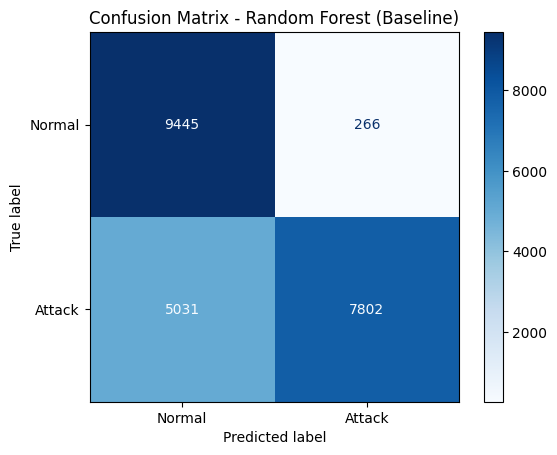

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Display the matrix with matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attack"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest (Baseline)")
plt.show()

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ------------------------------------------------------
# Step 4.1: Hyperparameter tuning using GridSearchCV
# ------------------------------------------------------ 

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced']
}

# Initialize the base model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,                         # 3-fold cross-validation
    scoring='f1',                 # optimize for f1-score (balances precision & recall)
    verbose=2,
    n_jobs=-1                     # use all CPU cores
)

# Run the grid search
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150]},
             scoring='f1', verbose=2)

In [9]:
# Best model
best_model_rf = grid_search.best_estimator_

# Predict
y_pred_best = best_model_rf.predict(x_test)

# Evaluate
print("Best Params:", grid_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_best))


Best Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



### Random Forest Hyperparameter Tuning Attempts

Several combinations of hyperparameters were tested using GridSearchCV with different objectives:

- Initial tuning used `scoring='f1'` to balance precision and recall.
  - Tried: `n_estimators=[100, 150]`, `max_depth=[10, 15, 20]`, etc.
  - Best recall: ~64%

- Second tuning focused on maximizing **recall** with `scoring='recall'`.
  - Increased `max_depth` to 25
  - Recall dropped slightly to ~62%, suggesting the model reached its limit.

These experiments led to the decision to explore other models such as Logistic Regression and XGBoost.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# ------------------------------------------------------
# Step 5: Create and train Logistic Regression Model
# ------------------------------------------------------ 

#  Initialize Logistic Regression with class_weight balanced
log_reg = LogisticRegression(
    class_weight='balanced',     # tells it to handle imbalance automatically
    max_iter=2000,               # allow more iterations to ensure convergence
    solver='saga',
    tol=0.01,                    # relax tolerance to prevdoes ent logistic regression from flagging warning that convergence has not occured
    random_state=42
)

# Train the model
log_reg.fit(x_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42,
                   solver='saga', tol=0.01)

Logistic Regression Accuracy: 0.544402058197303
Classification Report:
               precision    recall  f1-score   support

           0       0.01      0.00      0.00      9711
           1       0.56      0.96      0.70     12833

    accuracy                           0.54     22544
   macro avg       0.28      0.48      0.35     22544
weighted avg       0.32      0.54      0.40     22544



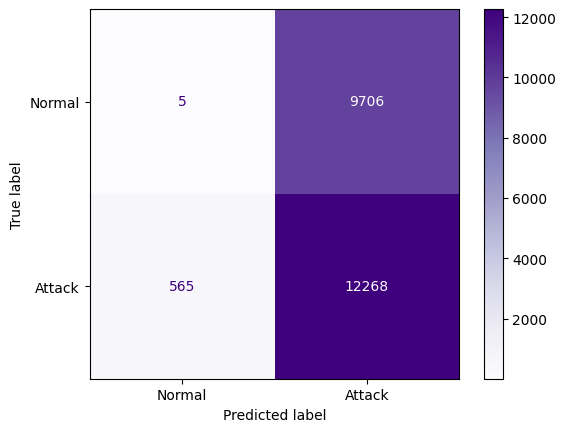

In [11]:
# Predict on test data and evaluate performance
y_pred_lr = log_reg.predict(x_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attack"])
disp.plot(cmap="Purples")

XGBoost Accuracy: 0.7878814762242725
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



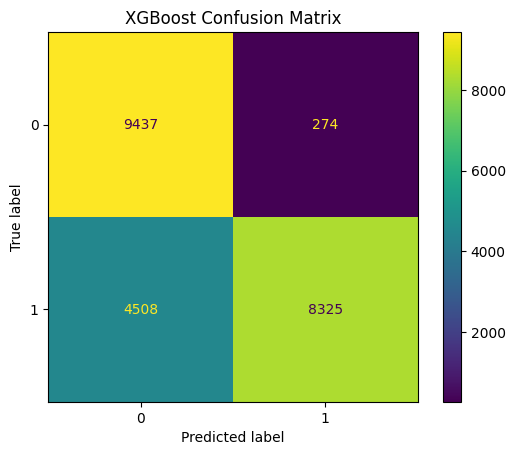

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# ------------------------------------------------------
# Step 6.0: Train and Evaluate XGBoost Classifier
# ------------------------------------------------------ 

# Initialize the model
xgb_model = XGBClassifier(
    eval_metric='logloss',        # sets a standard evaluation metric
    random_state=42               # ensures reproducibility
)

# Train the model
xgb_model.fit(x_train, y_train)

# Predict on test set
xgb_preds = xgb_model.predict(x_test)

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print("Classification Report:\n", classification_report(y_test, xgb_preds))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds)
plt.title("XGBoost Confusion Matrix")
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# ------------------------------------------------------
# Step 6.1: Tune XGBoost hyperparameters using GridSearchCV
# ------------------------------------------------------ 
# Trying different combinations of n_estimators, max_depth,
# learning_rate, subsample, and colsample_bytree to improve recall

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [6, 10],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='recall',     # focus on improving recall
    cv=3,                 # 3-fold cross-validation
    verbose=1,
    n_jobs=-1             # use all cores
)

grid_search.fit(x_train, y_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.2], 'max_depth': [6, 10],
                         'n_estimators': [100, 150], 'subsample': [0.8, 1.0]},
             scoring='recall', verbose=1)

Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 150, 'subsample': 1.0}
Accuracy: 0.7876596877217885
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



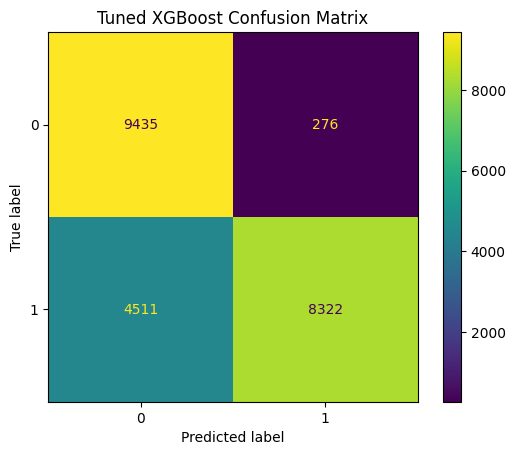

In [14]:
best_xgb = grid_search.best_estimator_
xgb_preds = best_xgb.predict(x_test)

print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print("Classification Report:\n", classification_report(y_test, xgb_preds))

# Optional: plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds)
plt.title("Tuned XGBoost Confusion Matrix")
plt.show()


In [ ]:
# 7.0: Scale the features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [37]:
# Save the feature columns for later use
import joblib 

feature_columns = x_train.columns.tolist()
joblib.dump(feature_columns, "../data/mlp_feature_columns.pkl")

['../data/mlp_feature_columns.pkl']

In [16]:
# 7.1: Convert to Pytorch Tensors and DataLoaders

import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert the scaled numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDatasets (pair inputs with labels)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders (for batching)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
# # 7.2: Define the MLP model

# import torch.nn as nn
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, 1),  # Output layer for binary classification
#             nn.Sigmoid()      # Sigmoid activation for binary output
#         )
    
#     def forward(self, x):
#         return self.net(x)

In [18]:
# import torch.optim as optim

# # instantiate model
# input_dim = x_train.shape[1]  # Number of features
# model = MLP(input_dim)

# # loss function and optimizer
# criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate of 0.001


In [19]:
# # 7.3: Train the MLP model
# num_epochs = 10  # Number of epochs to train

# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode
#     running_loss = 0.0

#     for inputs, labels in train_loader:
#         outputs = model(inputs).squeeze()
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()  # Zero the gradients
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
   
    



In [20]:
# # 7.4: Evaluate the MLP model

# from sklearn.metrics import classification_report

# # Set the model to evaluation mode
# model.eval()

# all_preds = []
# all_labels = []

# # Disable gradient calculation for inference
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs).squeeze()
#         preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
#         all_preds.extend(preds.tolist())
#         all_labels.extend(labels.tolist())

# # print classification report
# print(classification_report(all_labels, all_preds, target_names=["Normal", "Attack"]))

In [21]:
# import torch.nn as nn

# # Tuned MLP model 
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(0.4),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, 1),  # Output layer for binary classification
#             nn.Sigmoid()      # Sigmoid activation for binary output
#         )

#     def forward(self, x):
#         return self.net(x)

In [22]:
# import torch.optim as optim

# # Instantiate the model
# input_dim = x_train.shape[1] # Number of features
# model = MLP(input_dim)

# # Define the loss function and optimizer
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0005) # Lower learning rate for better convergence

# num_epochs = 30

In [23]:
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for inputs, labels in train_loader:
#         outputs = model(inputs).squeeze()
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     avg_loss = running_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [24]:
# from sklearn.metrics import classification_report

# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs).squeeze()
#         preds = (outputs >= 0.5).float()
#         all_preds.extend(preds.tolist())
#         all_labels.extend(labels.tolist())

# print(classification_report(all_labels, all_preds, target_names=["Normal", "Attack"]))


In [25]:
# import torch.nn as nn 

# # Deeper Tuned MLP model
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(0.4),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.net(x)

In [26]:
# import torch.optim as optim

# # Instantiate the model
# input_dim = x_train.shape[1]
# model = MLP(input_dim)

# # Define the loss function and optimizer
# criterion = nn.BCELoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# num_epochs = 50

In [27]:
# for epoch in range(num_epochs):
#     model.train()
#     running_loss =0.0
#     for inputs, labels in train_loader:
#         outputs = model(inputs).squeeze()
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     avg_loss = running_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [28]:
# from sklearn.metrics import classification_report

# # Set model to evaluation mode
# model.eval()

# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs).squeeze()
#         preds = (outputs >= 0.5).float()
#         all_preds.extend(preds.tolist())
#         all_labels.extend(labels.tolist())

# # Print classification report
# print(classification_report(all_labels, all_preds, target_names=["Normal", "Attack"]))

In [29]:
import torch.nn as nn

# Deeper tuned MLP model with BatchNorm and no final Sigmoid
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # Batch normalization 
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),   # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(64, 1)     # No Sigmoid here; we'll apply it in the loss function
        )

    def forward(self, x):
        return self.net(x)


In [30]:
import torch

# Calculate class imnbalance weights
attack_weight = len(df_train[df_train["label_binary"] == 0]) / len(df_train)
normal_weight = len(df_train[df_train["label_binary"] == 1]) / len(df_train)

# Create weighted bcewithlogits loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(attack_weight / normal_weight))

In [31]:
from torch.optim import AdamW

input_dim = x_train.shape[1]
model = MLP(input_dim)

optimizer = AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

num_epochs = 50


In [32]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/50], Loss: 0.0734
Epoch [2/50], Loss: 0.0347
Epoch [3/50], Loss: 0.0311
Epoch [4/50], Loss: 0.0268
Epoch [5/50], Loss: 0.0256
Epoch [6/50], Loss: 0.0242
Epoch [7/50], Loss: 0.0236
Epoch [8/50], Loss: 0.0222
Epoch [9/50], Loss: 0.0211
Epoch [10/50], Loss: 0.0203
Epoch [11/50], Loss: 0.0196
Epoch [12/50], Loss: 0.0190
Epoch [13/50], Loss: 0.0191
Epoch [14/50], Loss: 0.0183
Epoch [15/50], Loss: 0.0177
Epoch [16/50], Loss: 0.0171
Epoch [17/50], Loss: 0.0163
Epoch [18/50], Loss: 0.0164
Epoch [19/50], Loss: 0.0163
Epoch [20/50], Loss: 0.0145
Epoch [21/50], Loss: 0.0152
Epoch [22/50], Loss: 0.0146
Epoch [23/50], Loss: 0.0149
Epoch [24/50], Loss: 0.0142
Epoch [25/50], Loss: 0.0141
Epoch [26/50], Loss: 0.0140
Epoch [27/50], Loss: 0.0136
Epoch [28/50], Loss: 0.0130
Epoch [29/50], Loss: 0.0133
Epoch [30/50], Loss: 0.0131
Epoch [31/50], Loss: 0.0126
Epoch [32/50], Loss: 0.0127
Epoch [33/50], Loss: 0.0122
Epoch [34/50], Loss: 0.0119
Epoch [35/50], Loss: 0.0126
Epoch [36/50], Loss: 0.0117
E

In [45]:
# evaluate the model
 
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

model.eval()
all_outputs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        probs = torch.sigmoid(outputs)
        all_outputs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# calculate precision, recall and f1_score for different thresholds in order to find the best threshold based on attack recall, precision and f1_score
best_threshold = 0
best_f1 = 0

thresholds = [i / 100 for i in range(1, 100)]
print("Threshold | Precision | Recall | F1-Score")
print("------------------------------------------")

for t in thresholds:
    preds = [1 if p >= t else 0 for p in all_outputs]
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)

    print(f"{t:8.2f} | {prec:9.4f} | {rec:6.4f} | {f1:8.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}")


Threshold | Precision | Recall | F1-Score
------------------------------------------
    0.01 |    0.9238 | 0.7951 |   0.8546
    0.02 |    0.9288 | 0.7831 |   0.8497
    0.03 |    0.9418 | 0.7761 |   0.8510
    0.04 |    0.9433 | 0.7701 |   0.8480
    0.05 |    0.9447 | 0.7676 |   0.8470
    0.06 |    0.9466 | 0.7590 |   0.8425
    0.07 |    0.9491 | 0.7555 |   0.8413
    0.08 |    0.9503 | 0.7533 |   0.8404
    0.09 |    0.9509 | 0.7489 |   0.8379
    0.10 |    0.9566 | 0.7462 |   0.8384
    0.11 |    0.9574 | 0.7435 |   0.8370
    0.12 |    0.9576 | 0.7418 |   0.8360
    0.13 |    0.9576 | 0.7405 |   0.8352
    0.14 |    0.9579 | 0.7391 |   0.8344
    0.15 |    0.9582 | 0.7370 |   0.8332
    0.16 |    0.9582 | 0.7347 |   0.8317
    0.17 |    0.9584 | 0.7333 |   0.8309
    0.18 |    0.9589 | 0.7319 |   0.8301
    0.19 |    0.9590 | 0.7306 |   0.8294
    0.20 |    0.9589 | 0.7285 |   0.8280
    0.21 |    0.9589 | 0.7268 |   0.8269
    0.22 |    0.9591 | 0.7250 |   0.8258
    0.23 |   

In [46]:
# output the final classification report using the best threshold 
final_preds = [1 if p >= best_threshold else 0 for p in all_outputs]
print("Classification Report at Best Threshold:")
print(classification_report(all_labels, final_preds, target_names=["Normal", "Attack"]))


Classification Report at Best Threshold:
              precision    recall  f1-score   support

      Normal       0.77      0.91      0.84      9711
      Attack       0.92      0.80      0.85     12833

    accuracy                           0.85     22544
   macro avg       0.85      0.85      0.85     22544
weighted avg       0.86      0.85      0.85     22544



In [ ]:
# from sklearn.metrics import classification_report

# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs).squeeze()
#         outputs = torch.sigmoid(outputs)  # Apply Sigmoid manually
#         threshold = 0.1
#         preds = (outputs >= threshold).float()
#         all_preds.extend(preds.tolist())
#         all_labels.extend(labels.tolist())

# print(classification_report(all_labels, all_preds, target_names=["Normal", "Attack"]))


              precision    recall  f1-score   support

      Normal       0.74      0.96      0.83      9711
      Attack       0.96      0.75      0.84     12833

    accuracy                           0.84     22544
   macro avg       0.85      0.85      0.84     22544
weighted avg       0.86      0.84      0.84     22544



In [38]:
# Save the trained MLP model 
torch.save(model.state_dict(), "../results/mlp_model.pth")

# Save the fitted scaler
import joblib
joblib.dump(scaler, "../results/mlp_scaler.pkl")

['../results/mlp_scaler.pkl']

In [ ]:
import numpy as np

# Random Forest and XGBoost already have predict_proba
rf_probs = best_model_rf.predict_proba(x_test)[:, 1]  # Probability of class 1
xgb_probs = xgb_model.predict_proba(x_test)[:, 1]  # Probability of class 1

# For MLP, we already have tensor outputs (after sigmoid)
model.eval()
mlp_probs = []

with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs).squeeze()
        outputs = torch.sigmoid(outputs)  # Apply sigmoid
        mlp_probs.extend(outputs.tolist())

mlp_probs = np.array(mlp_probs)  # Convert to numpy array


In [ ]:
# Average the probabilities from RF, XGBoost, and MLP
ensemble_probs = (rf_probs + xgb_probs + mlp_probs) / 3

ensemble_preds = (ensemble_probs >= 0.5).astype(int)


In [ ]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, ensemble_preds, target_names=["Normal", "Attack"]))

NameError: name 'y_test' is not defined